<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo02_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [31]:
# Instalação de libs que não estão presentes no Colab
!pip install -q emoji
!pip install -q transformers --no-cache-dir
!pip install -q sentencepiece
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 85.3 MB/s 
     |████████████████████████████████| 6.6 MB 64.3 MB/s 
     |████████████████████████████████| 101 kB 56.0 MB/s 
     |████████████████████████████████| 1.2 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 529 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [32]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Importação de bibliotecas utilizadas no pré-processamento
import re
import emoji
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pt_core_news_sm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from IPython.display import display

In [34]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 350)
# configura tema dos gráficos
sns.set_theme(style="whitegrid")
#configura a barra de progressos para usar no apply
tqdm.pandas()
# Identifica device gpu ou cpu disponível
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Carregar arquivo CSV das bases unificadas e validar

In [55]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', 
                    sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [ ]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
8877,Rapaz eu nunca achei que fosse conhecer um cabra tão macho e tão verdadeiro em suas palavras... pense num cabra véi macho!😳👇👇👇👇,0
7533,*Não sabe ainda em qual candidato a presidente vc vai votar?*\n*Vou te ajudar*\n👇🏼👇🏼👇🏼👇🏼👇🏼👇🏼👇🏼\n\n*1° Pegue o número da sua idade.*\n*2° multiplique por 2.*\n*3° Some 34 ao resultado.*\n*4° Divide por 2.* \n*5° Diminua a sua idade.*\n*Resultado????*\n*Esse número você deverá votar para presidente* 😉,0
8881,"Olha o ""eleitor do Bolsonaro"" que foi xingar o Haddad na Missa - nota do PT. Na verdade, é um *petista passando por eleitor do Bolsonaro*. \n*Esse é Gérson Florindo, Presidente do PT de Ubatuba - SP*. \nSó tem *canalha* nesse partido! Não salva um 😡😡😡",1
7390,"E nós achávamos que este homem era louco. E olha o que ele disse há alguns anos atrás respondendo a uma pergunta ofensiva, imbecil e de baixo nível do jornalista Teodomiro Braga do Jornal do Brasil. Verdade extrema! 👇👇👇😳😳",0
9081,"*NOTÍCIA URGENTE PLANTÃO DA GLOBO*\n\nURGENTE: STJ acaba de deferir Habeas Corpus ao ex-presidente Lula.\nNo mérito da matéria, o Ministro suspende a decisão do TRF da 4 Região e permite que ele seja candidato nas próximas eleições.\nVeja a íntegra da decisão em https://g1.globo.com https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTu8G-W0iEFB7QbWgrqjsTtmofCMcY9Gp1MrRrI5XQ3LDeqGmG-cmSGKTqF",1


### Exploração e limpeza de dados

In [56]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', re.sub('(\n|\r)', ' ', texto))
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Mantem apenas caracteres alfanuméricos com e sem acentuação + pontuação
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = re.sub(r'(\.\.|\.\.\.|\.\.\.\.|\. \.)', '', texto)
    # Remove números concatenados ao final ou início de palavras
    texto = re.sub(r'(?:([a-z])\d+|\d([a-z]))', r'\1\2', texto)
    # Remove multiplos caracteres em branco
    return re.sub(r'\s+',' ', texto).strip()

dados["texto_limpo"] = dados.texto.progress_apply(limpar_textos)
dados["qtde_limpo"] = dados.texto_limpo.apply(
                                lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
display(dados[dados['texto'].str.len()<400].sample(n=5)[['classe', 'texto', 'texto_limpo', 'qtde_limpo']])

,classe,texto,texto_limpo,qtde_limpo
9375,1,"Adélio Bispo de Oliveira foi a mão que realizou os pensamentos de toda a elite bilionária, de toda a esquerda subsidiada, de toda a mídia comprada. Bolsonaro está cercado por milhões de assassinos, E ainda veremos toda essa gente alegando a violência que ele sofreu como prova de que o violento é ele. Esperem e verão.\nhttps://blogdoolavo.com/pe...","Adélio Bispo de Oliveira foi a mão que realizou os pensamentos de toda a elite bilionária, de toda a esquerda subsidiada, de toda a mídia comprada. Bolsonaro está cercado por milhões de assassinos, E ainda veremos toda essa gente alegando a violência que ele sofreu como prova de que o violento é ele. Esperem e verão.",56
9261,0,"Flavio Bolsonaro 177 Senador_RJ (@FlavioBolsonaro) tweetou: Infelizmente foi mais grave que esperávamos. A perfuração atingiu parte do fígado, do pulmão e da alça do intestino. Perdeu muito sangue, chegou no hospital com pressão de 10/3, quase morto... Seu estado agora parece estabilizado. Orem, por favor! https://twitter.com/FlavioBolsonaro/st...","Flavio Bolsonaro 177 SenadorRJ FlavioBolsonaro tweetou: Infelizmente foi mais grave que esperávamos. A perfuração atingiu parte do fígado, do pulmão e da alça do intestino. Perdeu muito sangue, chegou no hospital com pressão de 103, quase morto. Seu estado agora parece estabilizado. Orem, por favor",45
4742,1,"Coreia do Norte dispara diversos mísseis simultaneamente. A Coreia do Norte disparou diversos mísseis na noite de hoje, horario de Brasília (manhã do dia 08/06 na Coreia).","Coreia do Norte dispara diversos mísseis simultaneamente. A Coreia do Norte disparou diversos mísseis na noite de hoje, horario de Brasília manhã do dia 0806 na Coreia.",27
9079,0,"👏🏿👏🏿👏🏿Quem tem a ex mulher fazendo campanha a favor, é porque não deve ser um cara ruim, né?...😉","Quem tem a ex mulher fazendo campanha a favor, é porque não deve ser um cara ruim, né.",18
5100,1,"Se Temer for cassado, FHC tem grandes chances de assumir a presidência até 2018. O ex-presidente Fernando Henrique Cardoso tem grandes chances de assumir a presidência da república com um empurrãozinho do Congresso. Vamos explicar. O artigo 81 da Constituição Federal diz o seguinte: É cobra comendo cobra [...] o PMDB que ""comeu"" o PT [...] po...","Se Temer for cassado, FHC tem grandes chances de assumir a presidência até 2018. O ex-presidente Fernando Henrique Cardoso tem grandes chances de assumir a presidência da república com um empurrãozinho do Congresso. Vamos explicar. O artigo 81 da Constituição Federal diz o seguinte: É cobra comendo cobra . o PMDB que ""comeu"" o PT . poderá ser ""...",65


### Carga da spaCy para limpeza de dados

Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)  
Remove stopworks, mas a pontuação é mantida pois é relevante para o modelo.

In [57]:
nlp = pt_core_news_sm.load()
dados["texto_lematizado"] = dados.texto_limpo.progress_apply(
    lambda texto: " ".join(
          [token.lemma_ for token in nlp(texto)   # lematiza
          if not token.is_stop]))                 # se não é uma stopword
dados["qtde_lematizado"] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados.sample(n=5)[['classe', 'qtde_limpo', 'qtde_lematizado', 'texto_limpo', 'texto_lematizado']])

,classe,qtde_limpo,qtde_lematizado,texto_limpo,texto_lematizado
2135,0,631,327,"Grupo que abriu caixão por achar que mulher foi enterrada viva deve responder por violação funerária, diz polícia. Caso ocorreu no município de Riachão das Neves, no oeste do estado. Polícia acred...",abrir caixão achar mulher enterrar vivo responder violação funerário polícia caso ocorrer município Riachão Neves oeste polícia acreditar boato levar violação urna funerário pessoa abrir túmulo mu...
1063,0,849,443,"Supremo reserva julgamentos polêmicos para semana pré-recesso. Estão pautadas ações sobre poder da Polícia Federal para fechar delações, pedido de liberdade do empresário Joesley Batista e paralis...",Supremo reserva julgamento polêmico semana pré-recesso pautado ação Polícia Federal fechar delação pedir liberdade empresário Joesley Batista paralisação denúncia núcleo PMDB Supremo Tribunal Fede...
9438,0,20,13,"Observem este diálogo entre Jeca Tatu e Dom Pedro ll no filme O gato da Madame"" 1956 Mais atual impossível",observem diálogo Jeca Tatu Dom Pedro ll filme gato madame 1956 atual impossível
852,0,695,383,Fachin envia inquérito de Temer a Janot PGR tem 5 dias para decidir se denuncia. Presidente passou a ser investigado após delações de executivos da JBS ele tem negado todas as acusações. Documento...,fachin enviar inquérito Temer Janot PGR dia decidir denuncer presidente passar investigar delação executivo JBS negar acusação documento chegar PGR prazo decisão terminar terça 27 ministro Luiz Ed...
6717,1,116,68,"PF vasculha forro do Instituto Lula e apreende celulares, pen drives e computadores. Funcionárias do Instituto Lula informaram por meio de nota imprensa que a PF levou computadores, celulares e pe...",PF vasculha forro Instituto Lula apreender celular pen drives computador funcionária Instituto Lula informar nota imprenso PF levar computador celular pendrives instituição aproximadamente 60 home...


### O modelo BERTimbau é sensível ao CASE, precisa ser tratado 

In [58]:
# Remove linhas com mais de 10% de palavras em maiúsculo
antes = dados.shape[0]
dados['qtde_maiusculas'] = dados['texto_lematizado'].apply(
    lambda texto: len(re.findall("[A-Z][A-Z\d]+", texto)))
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_lematizado"])<0.1].copy()
# Das linhas que ficaram, capitaliza somente as palavras em MAIÚSCULO
dados['texto_limpo'] = dados['texto_limpo'].apply(
    lambda texto: re.sub("[A-Z][A-Z\d]+", 
    lambda grupo: grupo.group(0).capitalize(), texto))
dados['texto_lematizado'] = dados['texto_lematizado'].apply(
    lambda texto: re.sub("[A-Z][A-Z\d]+", 
    lambda grupo: grupo.group(0).capitalize(), texto))
dados.drop('qtde_maiusculas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}," +
        f" removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 9537, depois: 8808, removido: 729'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [59]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_lematizado'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8808, depois: 8661, removido: 147'

### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras lematizadas.

In [60]:
dados_menos_100_palavras = dados[dados["qtde_lematizado"]<100].copy()

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_lematizado'] == coluna_busca]).copy()
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_lematizado.apply(
      lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_lematizado"]<100].texto_lematizado.progress_apply(confere_duplicidade)
dados_menos_100_palavras = pd.DataFrame() #libera área
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_lematizado"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

  0%|          | 0/3324 [00:00<?, ?it/s]

'Qtde linhas antes: 8661, depois: 7802, removido: 859'

## Confere a distribuição de palavras nas classes

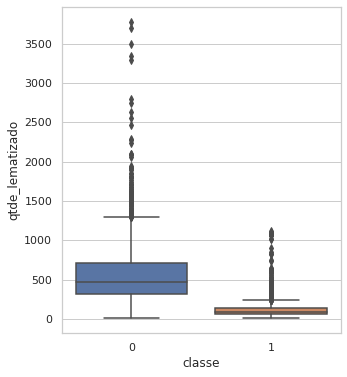

In [ ]:
ax, fig = plt.subplots(figsize=[5,6])
ax = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])

In [41]:
def grafico_distribuicao(dfplot, distrib_dados):
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 2000, 100)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.countplot(x="classe", data=distrib_dados)
  axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
  axes2.set_title('Distribuição de classes', fontsize=14)
  axes2.set_ylabel('quantidade')

[0, 1]

[3837, 3965]

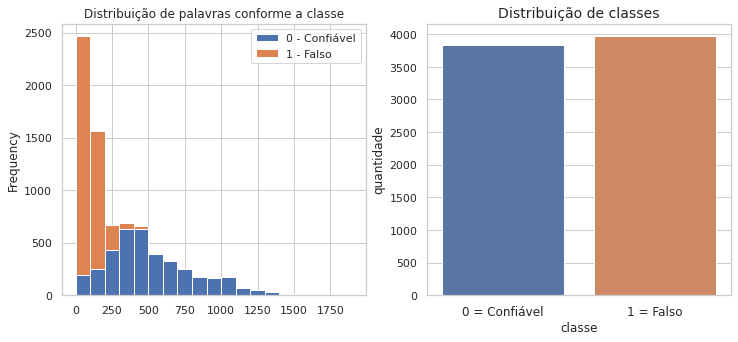

In [42]:
grafico_distribuicao(dados.pivot(columns='classe').qtde_lematizado, dados)
distribuicao = dados.groupby('classe').qtde_lematizado.count()
display(distribuicao.index.to_list(), distribuicao.to_list())

In [63]:
dados.query(
    'qtde_lematizado < 50 or qtde_lematizado > 1000'
).groupby('classe').qtde_lematizado.count()

classe
0    547
1    552
Name: qtde_lematizado, dtype: int64

In [64]:
antes = dados.shape[0]
dados = dados.query(
    'qtde_lematizado >= 50 and qtde_lematizado <= 1000'
).copy()
display(f"Qtde antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")
display(f"Maximo de palavras: {dados['qtde_lematizado'].max()}", f"Mínimo de palavras: {dados['qtde_lematizado'].min()}")

'Qtde antes: 7802, depois: 6703, removido: 1099'

'Maximo de palavras: 1000'

'Mínimo de palavras: 50'

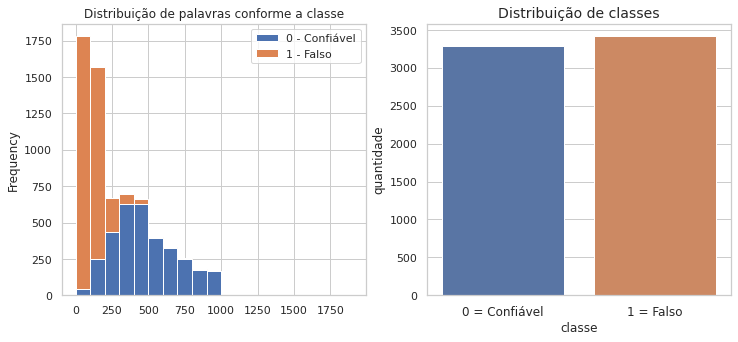

In [65]:
grafico_distribuicao(dados.pivot(columns='classe').qtde_lematizado, dados)

### Carrega o modelo pré-treinado de sumarização

In [ ]:
# configura o device cpu ou gpu conforme disponibilidade
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'
# nome do modelo no portal HuggingFaces
model_name = "seidel/plsum-base-ptt5"

# carrega tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)
# carrega pesos do modelo "PLSUM"
model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device_disponivel)

### Separação e salvamento do processo parcial antes de rodar o modelo que leva algumas horas

In [ ]:
# Divide o dataframe e já salva os arquivos parciais para evitar perda por falha de conexão
df_menor = dados.query('qtde_lematizado <= 300').copy() 
df_maior = dados.query('qtde_lematizado > 300').copy()
df_menor.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_menor.csv', sep = ',')
df_maior.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_maior.csv', sep = ',')
display(f"Menor: {df_menor.shape[0]}; Maior: {df_maior.shape[0]}")

'Menor: 4019; Maior: 2684'

### Principal método que gera os tokens, sumariza e transforma os tokens de volta em palavras

In [ ]:
def resumir_textos(texto):
  # tokeniza o texto de entrada
  input_ids = tokenizer([texto],
      return_tensors="pt",        # retorna o tensores pytorch
      max_length=1500,            # tamanho máximo de entrada
      truncation=True             # caso exceder, trunca, já limitei
  )["input_ids"]
  t_tokens = input_ids.to(device_disponivel) 
  # gera tokens de sumarização
  output_ids = model_pt.generate(   
      input_ids=t_tokens,         # tokens de entrada
      max_length=300,             # tamanho máximo
      min_length=50,              # tamanho mínimo
      no_repeat_ngram_size=2,     # n-grans que não deve repetir
      length_penalty=1.5,         # penalti por tamanho, > 1 aproxima max_len
      num_beams=4,                # valor para algoritmo de pesquisa heurística
  )[0]
  # decodifica a saída (converter tokens numéricos para texto)
  resumo = tokenizer.decode(
      output_ids,
      skip_special_tokens=True,           # remove tokens especiais
      clean_up_tokenization_spaces=False  # mantem espaços ao decodificar
  )
  return resumo

In [ ]:
# Roda resumo em texto limpo pois ele será lematizado posteriormente
df_maior["texto_lematizado"] = df_maior['texto_limpo'].progress_apply(resumir_textos)
df_maior["texto_lematizado"] = df_maior.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)

# Depois do resumo roda novamente a lemtatização
df_maior["texto_lematizado"] = df_maior["texto_lematizado"].progress_apply(
    lambda texto: " ".join(
          [token.lemma_ for token in nlp(texto)   
          if not token.is_stop]))          
df_maior["qtde_lematizado"] = df_maior["texto_lematizado"].apply(
    lambda texto: len(re.findall(r"[\w']+", texto)))

In [ ]:
dados_novo = pd.concat(
    [df_menor, df_maior],
    ignore_index=True,
    copy=True,
)

### Plota novamente para ver como ficou

In [ ]:
def grafico_distribuicao_boxplot(dados):
  dfplot = dados.pivot(columns='classe').qtde_lematizado
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 300, 30)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"], ax=axes[1])
  axes2.set_ylabel('Qtde_Palavras')  

  axes3 = sns.countplot(x="classe", data=dados, ax=axes[2])
  axes3.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
  axes3.set_title('Distribuição de classes', fontsize=14)
  axes3.set_ylabel('quantidade')  

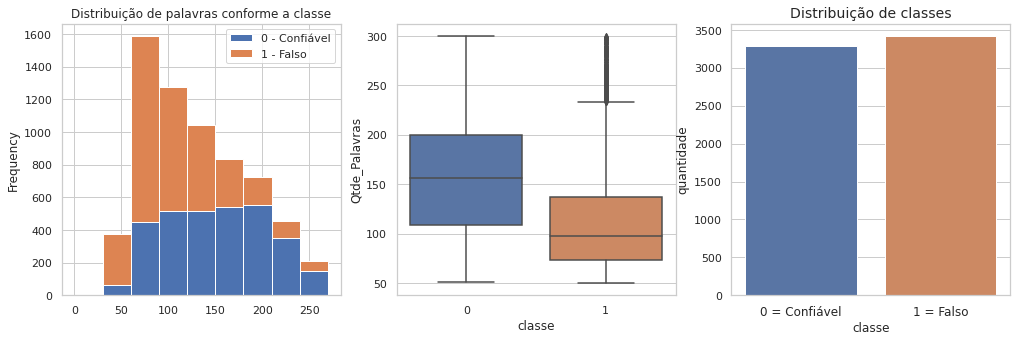

In [ ]:
grafico_distribuicao_boxplot(dados_novo)

### Salva resultado para usar na exploração

In [ ]:
# Salva novamente os dados para uso no notebook do próximo passo.
dados_novo.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',', index=False)